In [1]:
import numpy as np
import math
import open3d as o3d
import cv2
import matplotlib.pyplot as plt
import copy

In [9]:
RGDB_Image = o3d.geometry.RGBDImage.create_from_color_and_depth(
    o3d.geometry.Image(colorImage),
    o3d.geometry.Image(np.array(rawDepthImage).astype('uint16')),
    convert_rgb_to_intensity=False,
    depth_scale=1000.0)
width,height,fx,fy,ppx,ppy = 1280,720,635.1203002929688,635.1203002929688,634.2567138671875,356.49176025390625 # d405 instrinsics
pcd = o3d.geometry.PointCloud.create_from_rgbd_image(
    RGDB_Image,
    o3d.camera.PinholeCameraIntrinsic(width,height,fx,fy,ppx,ppy),
    project_valid_depth_only=True
)

baseFrame = o3d.geometry.TriangleMesh.create_coordinate_frame()
o3d.io.write_point_cloud("front1.ply",pcd,compressed=False)
# o3d.visualization.draw([pcd,baseFrame])

True

In [10]:
pcd = o3d.io.read_point_cloud("front1.ply")
o3d.visualization.draw([pcd])

In [2]:
from PIL import Image
from skimage import io,measure
import cv2 as cv
import matplotlib.pyplot as plt
import scipy.ndimage as nd
import numpy as np

<Figure size 640x480 with 0 Axes>

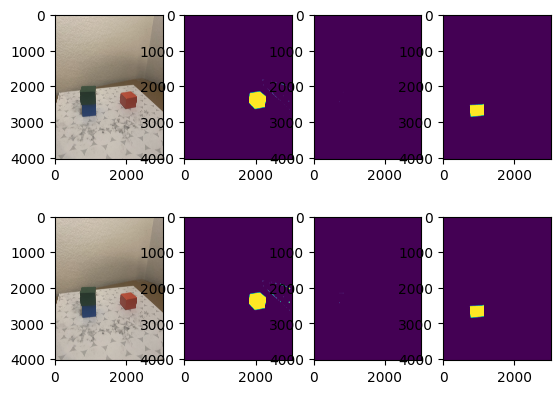

In [3]:
fig = plt.figure()
f,axarr = plt.subplots(2,4)
mask1,mask2 = None,None
for i in range(1866,1867):
    path = f"IMG_{i}.jpeg"
    img = io.imread(path)
    # convert image to hsv
    hsv = cv.cvtColor(img,cv.COLOR_RGB2HSV)
    # HSV visual - https://stackoverflow.com/questions/10948589/choosing-the-correct-upper-and-lower-hsv-boundaries-for-color-detection-withcv
    redMask = cv.inRange(hsv,(0,110,20),(15,255,255))
    greenMask = cv.inRange(hsv,(35,90,10),(85,255,255))
    blueMask = cv.inRange(hsv,(95,90,20),(130,255,255)) 
    # binary closing with 10 x 10 kernel (dilation then erosion) to fill in gaps
    closedRedMask = nd.binary_closing(redMask,np.ones((10,10)),iterations=5)
    closedGreenMask = nd.binary_closing(greenMask,np.ones((10,10)),iterations=5)
    closedBlueMask = nd.binary_closing(blueMask,np.ones((10,10)),iterations=5)
    mask1,mask2 = closedGreenMask,closedBlueMask
    axarr[0][0].imshow(img)
    axarr[0][1].imshow(redMask)
    axarr[0][2].imshow(greenMask)
    axarr[0][3].imshow(blueMask)
    axarr[1][0].imshow(img)
    axarr[1][1].imshow(closedRedMask)
    axarr[1][2].imshow(closedGreenMask)
    axarr[1][3].imshow(closedBlueMask)


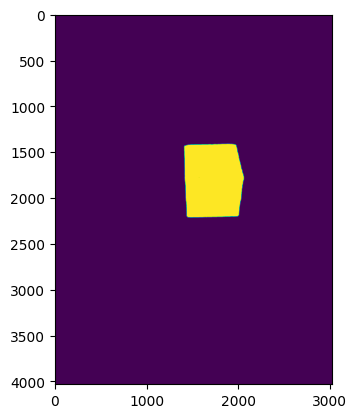

In [24]:
def getMask(img,hsvBounds):
    # :img 3-channel rgb image as numpy array
    # :hsvBounds tuple containing 2 triplets with hsv bounds. ex: (0,110,20),(15,255,255)
    # Segments image based on bounds in hsv color space (1st converts image from rgb space to hsv)
    # returns a 1-channel numpy array that results from segmentation
    # convert image to hsv
    hsv = cv.cvtColor(img,cv.COLOR_RGB2HSV)
    mask = cv.inRange(img,hsvBounds)
    # binary closing with 10 x 10 kernel (dilation then erosion) to fill in gaps
    closedMask = nd.binary_closing(mask,np.ones(10,10),iterations=5)
    return closedMask

def getBlocksFromImages(colorImage,depthImage):
    # mask the depth image using the monochromatic segmented image so that only blocks have defined values
    redMask = getMask(colorImage,(0,110,20),(15,255,255))
    greenMask = getMask(colorImage,(35,90,10),(85,255,255))
    blueMask = getMask(colorImage,(95,90,20),(130,255,255))
    
    '''
    redDepthImage = np.multiply(depthImage,redMask)
    greenDepthImage = np.multiply(depthImage,greenMask)
    blueDepthImage = np.multiply(depthImage,blueMask)
    
    # depthImageSeg = np.multiply(depthImage,mask)
    images.append(redDepthImage)
    images.append(greenDepthImage)
    images.append(blueDepthImage)
    # SEGMENT PCD INTO RED,GREEN,BLUE BLOCKS
    redRGDB_Image = o3d.geometry.RGBDImage.create_from_color_and_depth(
        o3d.geometry.Image(regImage),
        o3d.geometry.Image(np.array(redDepthImage).astype('uint16')),
        convert_rgb_to_intensity=False,
        depth_scale=1000.0)

    greenRGDB_Image = o3d.geometry.RGBDImage.create_from_color_and_depth(
        o3d.geometry.Image(regImage),
        o3d.geometry.Image(np.array(greenDepthImage).astype('uint16')),
        convert_rgb_to_intensity=False,
        depth_scale=1000.0)
    
    blueRGBD_Image = o3d.geometry.RGBDImage.create_from_color_and_depth(
        o3d.geometry.Image(regImage),
        o3d.geometry.Image(np.array(blueDepthImage).astype('uint16')),
        convert_rgb_to_intensity=False,
        depth_scale=1000.0)
    
    redPCD = o3d.geometry.PointCloud.create_from_rgbd_image(
        redRGDB_Image,
        o3d.camera.PinholeCameraIntrinsic(320,240,320,240,160,120),
        project_valid_depth_only=True
    )
    greenPCD = o3d.geometry.PointCloud.create_from_rgbd_image(
        greenRGDB_Image,
        o3d.camera.PinholeCameraIntrinsic(320,240,320,240,160,120),
        project_valid_depth_only=True
    )
    bluePCD = o3d.geometry.PointCloud.create_from_rgbd_image(
        blueRGBD_Image,
        o3d.camera.PinholeCameraIntrinsic(320,240,320,240,160,120),
        project_valid_depth_only=True
    )
    
    # flip point clouds since they start upside down
    # redPCD.transform([[1,0,0,0],[0,-1,0,0],[0,0,-1,0],[0,0,0,1]])
    # greenPCD.transform([[1,0,0,0],[0,-1,0,0],[0,0,-1,0],[0,0,0,1]])
    # bluePCD.transform([[1,0,0,0],[0,-1,0,0],[0,0,-1,0],[0,0,0,1]])
    redPCD.paint_uniform_color([1,0,0])
    greenPCD.paint_uniform_color([0,1,0])
    bluePCD.paint_uniform_color([0,0,1])
    redBlock = Block("redBlock",redPCD)
    greenBlock = Block("greenBlock",greenPCD)
    blueBlock = Block("blueBlock",bluePCD)
    showImages(images)
    o3d.visualization.draw([redPCD])
    '''
    return (redBlock,greenBlock,blueBlock)

In [22]:
print(hsv)

[[[ 16  16 173]
  [ 16  16 172]
  [ 14  19 175]
  ...
  [ 18  31 139]
  [ 18  32 136]
  [ 18  31 138]]

 [[ 16  16 174]
  [ 16  16 171]
  [ 14  19 173]
  ...
  [ 18  31 141]
  [ 18  31 139]
  [ 18  31 142]]

 [[ 16  16 173]
  [ 16  17 169]
  [ 14  20 170]
  ...
  [ 18  31 142]
  [ 18  31 142]
  [ 18  30 144]]

 ...

 [[  0   0 139]
  [  0   0 140]
  [  0   0 142]
  ...
  [ 21  66 105]
  [ 21  66 105]
  [ 21  66 104]]

 [[  0   0 138]
  [  0   0 140]
  [  0   0 142]
  ...
  [ 20  62 107]
  [ 21  64 107]
  [ 21  64 107]]

 [[  0   0 138]
  [  0   0 141]
  [  0   0 142]
  ...
  [ 20  62 107]
  [ 21  66 104]
  [ 21  66 104]]]


In [29]:
# 1860
# 1866
from skimage.io import imread
from skimage.io import imread_collection
    
    



IMG_1843.jpeg
IMG_1844.jpeg
IMG_1845.jpeg
IMG_1846.jpeg
IMG_1847.jpeg
IMG_1848.jpeg
IMG_1849.jpeg
IMG_1850.jpeg
IMG_1851.jpeg
IMG_1852.jpeg
IMG_1853.jpeg
IMG_1854.jpeg
IMG_1855.jpeg
IMG_1856.jpeg
IMG_1857.jpeg
IMG_1858.jpeg
IMG_1859.jpeg
IMG_1860.jpeg
IMG_1861.jpeg
IMG_1862.jpeg
IMG_1863.jpeg
IMG_1864.jpeg
IMG_1865.jpeg
IMG_1866.jpeg


In [1]:
import skimage
testData = skimage.io.ImageCollection(["*.jpeg"])

In [8]:
testData[2]

array([[[166, 162, 153],
        [167, 163, 154],
        [171, 164, 156],
        ...,
        [139, 119,  92],
        [139, 119,  92],
        [141, 121,  94]],

       [[167, 163, 154],
        [167, 163, 154],
        [169, 162, 154],
        ...,
        [138, 118,  91],
        [136, 116,  89],
        [137, 117,  90]],

       [[171, 167, 158],
        [171, 167, 158],
        [173, 166, 158],
        ...,
        [139, 119,  92],
        [137, 117,  90],
        [138, 118,  91]],

       ...,

       [[ 58,  41,  11],
        [ 52,  35,   5],
        [ 52,  35,   5],
        ...,
        [121, 100,  73],
        [124, 103,  76],
        [119,  98,  71]],

       [[ 52,  35,   5],
        [ 50,  33,   3],
        [ 49,  32,   2],
        ...,
        [121, 100,  73],
        [121, 100,  73],
        [119,  98,  71]],

       [[ 52,  35,   5],
        [ 55,  38,   8],
        [ 56,  39,   9],
        ...,
        [121, 100,  73],
        [119,  98,  71],
        [122, 101,  74]]

In [49]:
c[0].shape

(4032, 3024, 3)

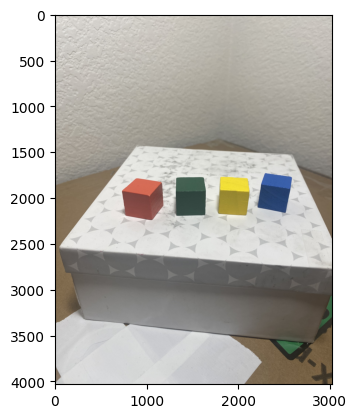

In [7]:
plt.ion()
plt.imshow(testData[0])